In [2]:
#activate env
#myenv\Scripts\activate


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout
from keras.layers import LSTM

In [4]:
df = pd.read_csv('XAU_1d_data_2004_to_2024-09-20.csv')
df

,Date,Time,Open,High,Low,Close,Volume
0,2004.06.11,00:00,384.00,384.80,382.80,384.10,272
1,2004.06.14,00:00,384.30,385.80,381.80,382.80,1902
2,2004.06.15,00:00,382.80,388.80,381.10,388.60,1951
3,2004.06.16,00:00,387.10,389.80,382.60,383.80,2014
4,2004.06.17,00:00,383.60,389.30,383.00,387.60,1568
...,...,...,...,...,...,...,...
5200,2024.09.10,00:00,2506.13,2518.37,2500.15,2516.71,75158
5201,2024.09.11,00:00,2516.59,2528.88,2501.15,2512.27,81323
5202,2024.09.12,00:00,2512.06,2560.12,2511.01,2559.03,79038
5203,2024.09.13,00:00,2558.19,2586.09,2556.74,2580.30,82666


In [5]:
df.drop(columns=['Time'], inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5205 entries, 0 to 5204
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    5205 non-null   datetime64[ns]
 1   Open    5205 non-null   float64       
 2   High    5205 non-null   float64       
 3   Low     5205 non-null   float64       
 4   Close   5205 non-null   float64       
 5   Volume  5205 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 244.1 KB


In [7]:
fig = px.line(y=df.Close, x=df.Date)
fig.update_traces(line_color='black') 
fig.update_layout(xaxis_title="Date", 
                  yaxis_title="Scaled Price",
                  title={'text': "Gold Price History Data", 'y':0.95, 'x':0.5, 'xanchor':'center', 'yanchor':'top'})

In [8]:
test_size = df[df.Date.dt.year >= 2023].shape[0]
test_size

441

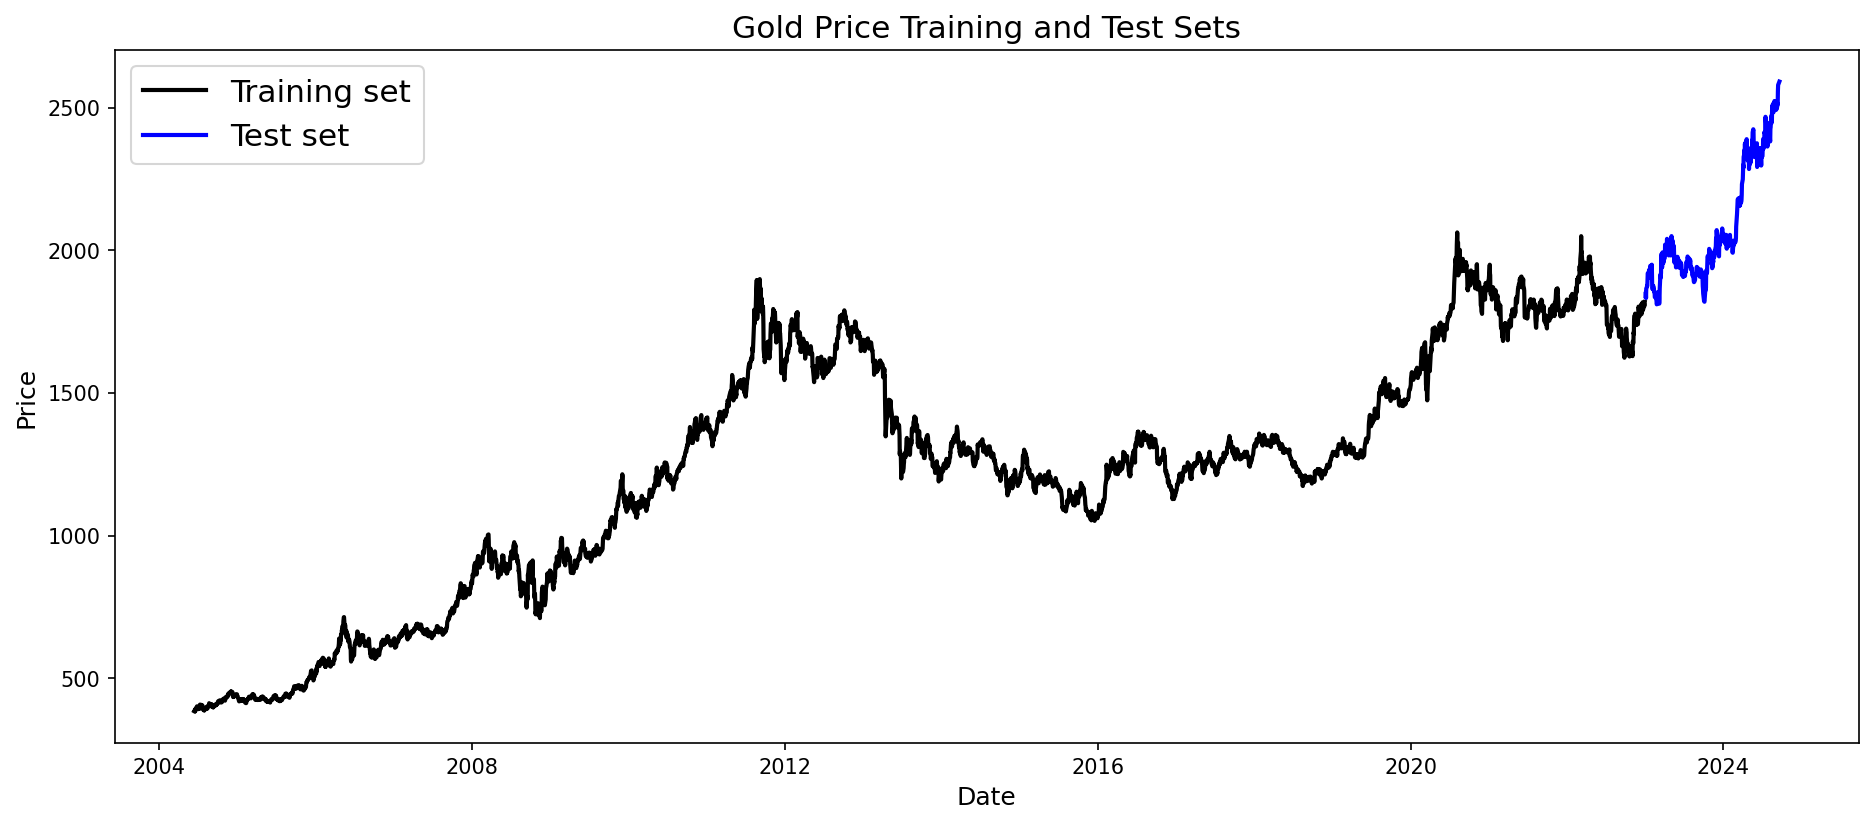

In [9]:
plt.figure(figsize=(15, 6), dpi=150)
plt.plot(df.Date[:-test_size], df.Close[:-test_size], color='black', lw=2)
plt.plot(df.Date[-test_size:], df.Close[-test_size:], color='blue', lw=2)
plt.title('Gold Price Training and Test Sets', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training set', 'Test set'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

In [10]:
scaler = MinMaxScaler()
scaler.fit(df.Close.values.reshape(-1,1))

MinMaxScaler()

Tanitó

In [11]:
window_size = 60

train_data = df.Close[:-test_size]
train_data = scaler.transform(train_data.values.reshape(-1,1))

X_train = []
y_train = []

for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-window_size:i, 0])
    y_train.append(train_data[i, 0])

Tesztelő

In [12]:
test_data = df.Close[-test_size-60:]
test_data = scaler.transform(test_data.values.reshape(-1,1))

X_test = []
y_test = []

for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-window_size:i, 0])
    y_test.append(test_data[i, 0])

In [13]:
X_train = np.array(X_train)
X_test  = np.array(X_test)
y_train = np.array(y_train)
y_test  = np.array(y_test)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (-1,1))
y_test  = np.reshape(y_test, (-1,1))

print('X_train Shape: ', X_train.shape)
print('y_train Shape: ', y_train.shape)
print('X_test Shape:  ', X_test.shape)
print('y_test Shape:  ', y_test.shape)

X_train Shape:  (4704, 60, 1)
y_train Shape:  (4704, 1)
X_test Shape:   (441, 60, 1)
y_test Shape:   (441, 1)


In [14]:
def define_model():
    input1 = Input(shape=(window_size,1))
    x = LSTM(units = 64, return_sequences=True)(input1)  
    x = Dropout(0.2)(x)
    x = LSTM(units = 64, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(units = 64)(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='softmax')(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[dnn_output])
    model.compile(loss='mean_squared_error', optimizer='Nadam')
    model.summary()
    
    return model

model = define_model()
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_split=0.1, verbose=1)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,057 (332.25 KB)

 Trainable params: 85,057 (332.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 0.0760 - val_loss: 0.0802
Epoch 2/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0312 - val_loss: 0.0788
Epoch 3/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0322 - val_loss: 0.0781
Epoch 4/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0310 - val_loss: 0.0795
Epoch 5/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0292 - val_loss: 0.0844
Epoch 6/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0314 - val_loss: 0.0775
Epoch 7/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0310 - val_loss: 0.0809
Epoch 8/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0298 - val_loss: 0.0813
Epoch 9/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.0309 - val_loss: 0.0801
Epoch 10/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0297 - val_loss: 0.0940
Epoch 11/150
133/133 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - loss: 0.0265 - val_loss: 0.0761
Epoch 12/150
133/133 ━━━━━━━━━

In [15]:
result = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test) 

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0038   
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


In [16]:
MAPE = mean_absolute_percentage_error(y_test, y_pred)
Accuracy = 1 - MAPE

In [17]:
print("Test Loss:", result)
print("Test MAPE:", MAPE)
print("Test Accuracy:", Accuracy)

Test Loss: 0.013526499271392822
Test MAPE: 0.09358171693542143
Test Accuracy: 0.9064182830645786


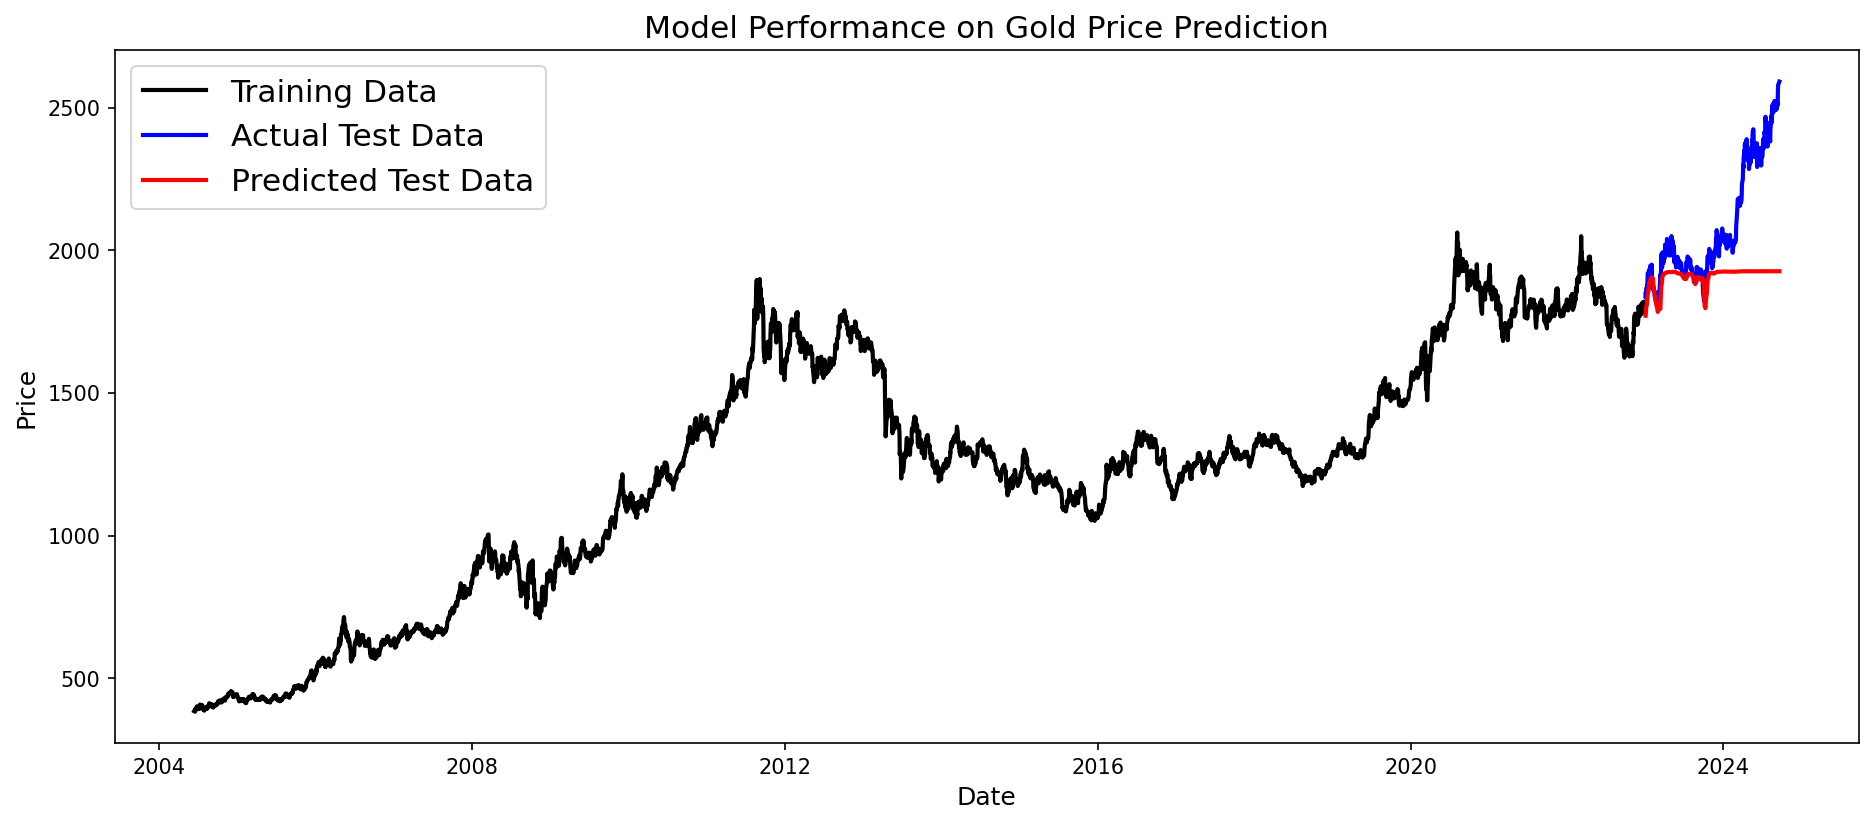

In [18]:
y_test_true = scaler.inverse_transform(y_test)
y_test_pred = scaler.inverse_transform(y_pred)

plt.figure(figsize=(15, 6), dpi=150)
plt.plot(df['Date'].iloc[:-test_size], scaler.inverse_transform(train_data), color='black', lw=2)
plt.plot(df['Date'].iloc[-test_size:], y_test_true, color='blue', lw=2)
plt.plot(df['Date'].iloc[-test_size:], y_test_pred, color='red', lw=2)
plt.title('Model Performance on Gold Price Prediction', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(['Training Data', 'Actual Test Data', 'Predicted Test Data'], loc='upper left', prop={'size': 15})
plt.show()

Model javítása

Látható, hogy a nagy ugrást nem tudja a modell lekövetni

- early stopping
- softmax activation helyett, ami inkább klasszifikációra jó, relu használása
- megnövelt window_size

In [ ]:
from keras.callbacks import EarlyStopping

window_size = 120

X_train = []
y_train = []

for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-window_size:i, 0])
    y_train.append(train_data[i, 0])

X_test = []
y_test = []

for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-window_size:i, 0])
    y_test.append(test_data[i, 0])

X_train = np.array(X_train)
X_test  = np.array(X_test)
y_train = np.array(y_train)
y_test  = np.array(y_test)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (-1,1))
y_test  = np.reshape(y_test, (-1,1))

def define_model_updated():
    input1 = Input(shape=(window_size, 1))
    x = LSTM(units=64, return_sequences=True)(input1)  
    x = Dropout(0.2)(x)
    x = LSTM(units=64, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(units=64)(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='relu')(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[dnn_output])
    model.compile(loss='mean_squared_error', optimizer='Nadam')
    model.summary()
    
    return model

model_updated = define_model_updated()

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_updated = model_updated.fit(
    X_train, y_train, 
    epochs=150, 
    batch_size=32, 
    validation_split=0.1, 
    verbose=1, 
    callbacks=[early_stopping]
)

result_updated = model_updated.evaluate(X_test, y_test)
y_pred_updated = model_updated.predict(X_test)

MAPE_updated = mean_absolute_percentage_error(y_test, y_pred_updated)
Accuracy_updated = 1 - MAPE_updated

print("Test Loss:", result_updated)
print("Test MAPE:", MAPE_updated)
print("Test Accuracy:", Accuracy_updated)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 120, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 120, 64)        │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 120, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 120, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 120, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,057 (332.25 KB)

 Trainable params: 85,057 (332.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
131/131 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - loss: 0.0172 - val_loss: 8.1218e-04
Epoch 2/150
131/131 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - loss: 0.0011 - val_loss: 9.0002e-04
Epoch 3/150
131/131 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - loss: 0.0010 - val_loss: 0.0015
Epoch 4/150
131/131 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 8.6032e-04 - val_loss: 0.0037
Epoch 5/150
131/131 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - loss: 7.1715e-04 - val_loss: 0.0012
Epoch 6/150
131/131 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - loss: 5.7150e-04 - val_loss: 0.0018
Epoch 7/150
131/131 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - loss: 5.5268e-04 - val_loss: 0.0028
Epoch 8/150
131/131 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - loss: 5.1062e-04 - val_loss: 3.6533e-04
Epoch 9/150
131/131 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - loss: 4.3236e-04 - val_loss: 3.0856e-04
Epoch 10/150
131/131 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - loss: 4.6340e-04 - val_loss: 2.7430e-04
Epoch 11/150
131/131 ━━━━━━━━━━━━━━━━━━━━ 7s 50ms/step - loss: 4.0765e

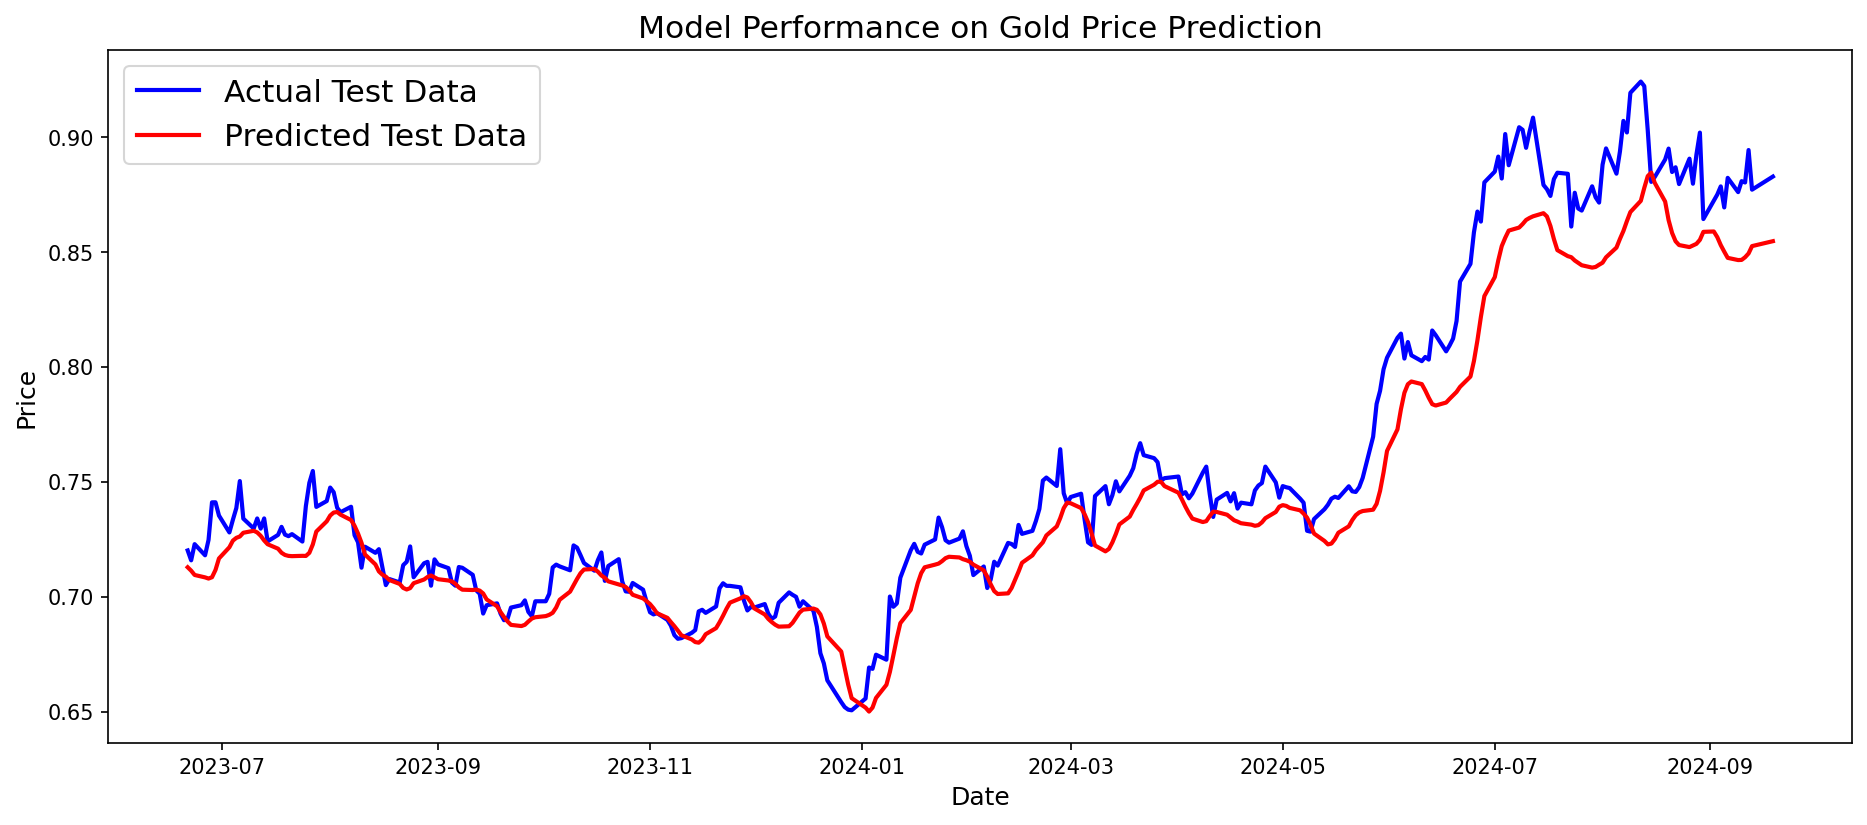

In [ ]:

y_test_pred_aligned = y_pred_updated.flatten()
y_test_true_aligned = y_test.flatten()

test_dates = df['Date'].iloc[-test_size:][window_size:]

plt.figure(figsize=(15, 6), dpi=150)
plt.plot(test_dates, y_test_true_aligned[:len(test_dates)], color='blue', lw=2, label='Actual Test Data')
plt.plot(test_dates, y_test_pred_aligned[:len(test_dates)], color='red', lw=2, label='Predicted Test Data')
plt.title('Model Performance on Gold Price Prediction', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(loc='upper left', prop={'size': 15})
plt.show()


In [34]:
from keras.models import load_model

model_path = "lstm_gold_price_model.keras"
model_updated.save(model_path)
print(f"Model saved to {model_path}")



Model saved to lstm_gold_price_model.keras
